In [1]:
# Getting the data generators for the training and validation sets
import os
import sys

module_path = os.path.abspath('../utils')
print("Adding to sys.path:", module_path)
sys.path.append(module_path)

from data_prep import get_data_generators
train_gen, valid_gen, df = get_data_generators('../data/pokemon.csv', '../data/pokemon-img/pokemon/pokemon/', img_size=(224,224), batch_size=16)

Adding to sys.path: c:\Users\halod\Documents\Projects\poke_classy_clean\utils

{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Found 280 validated image filenames.
Found 721 validated image filenames.


x_batch: (16, 224, 224, 3) dtype: float32
min: -123.68 max: 151.061


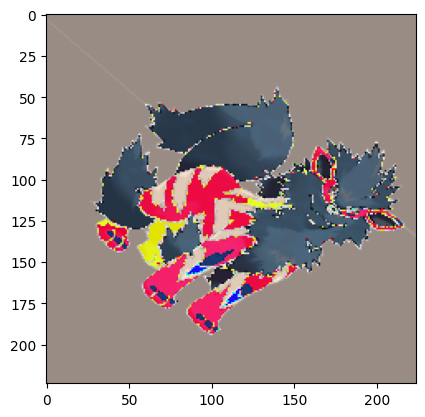

In [8]:
import matplotlib.pyplot as plt
x_batch, y_batch = next(iter(train_gen))
print("x_batch:", x_batch.shape, "dtype:", x_batch.dtype)
print("min:", x_batch.min(), "max:", x_batch.max())

plt.imshow(x_batch[0].astype("uint8") )
plt.show()


In [26]:
from tensorflow.keras.applications import ResNet50
# from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# defining the model based on the base model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision,Recall, AUC
from tensorflow.keras.regularizers import l2

# freeze the base
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.Dense(18, activation='sigmoid', kernel_regularizer=l2(1e-4))  # 18 is the number of pokemon types so 18 classes
])

model.compile(
    optimizer=Adam(1e-3),
    loss=BinaryCrossentropy(),
    metrics=[AUC(name='auc', multi_label=True), Precision(name='precision'), Recall(name='recall')]

)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 18)                36882     
                                                                 
Total params: 23624594 (90.12 MB)
Trainable params: 36882 (144.07 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,  
    callbacks=[EarlyStopping(
        monitor='val_auc',
        patience=5,
        restore_best_weights=True
    )]
)

Epoch 1/20
46/46 [==============================] - 32s 654ms/step - loss: 0.4124 - auc: 0.5173 - precision: 0.1115 - recall: 0.0528 - val_loss: 0.3473 - val_auc: 0.5810 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
46/46 [==============================] - 28s 612ms/step - loss: 0.3260 - auc: 0.6125 - precision: 0.2378 - recall: 0.0676 - val_loss: 0.3331 - val_auc: 0.6432 - val_precision: 0.7500 - val_recall: 0.0068
Epoch 3/20
46/46 [==============================] - 28s 615ms/step - loss: 0.2898 - auc: 0.6943 - precision: 0.3694 - recall: 0.1139 - val_loss: 0.3324 - val_auc: 0.6753 - val_precision: 0.6296 - val_recall: 0.0386
Epoch 4/20
46/46 [==============================] - 29s 621ms/step - loss: 0.2759 - auc: 0.7263 - precision: 0.4016 - recall: 0.1435 - val_loss: 0.3135 - val_auc: 0.6921 - val_precision: 0.6500 - val_recall: 0.0295
Epoch 5/20
46/46 [==============================] - 28s 617ms/step - loss: 0.2663 - auc: 0.7529 - precision: 0.4365 - recall: 0.1685

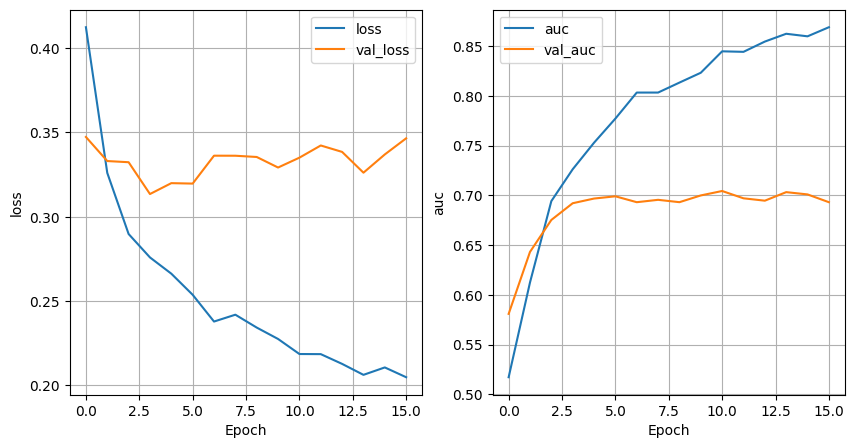

In [28]:
h = history
keys = list(h.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(h.history[keys[idx]], label=keys[idx])
    axes[idx].plot(h.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

In [29]:

# 1. Unfreeze last ~30 layers of the base EfficientNet
# (assuming your model = Sequential([base_model, ...]))
for layer in base_model.layers:
    layer.trainable = False

# Only keep the very last block + head trainable (e.g., last 20–30 layers)
for layer in base_model.layers[-25:]:
    layer.trainable = True

# 2. Recompile with a much smaller LR
model.compile(
    optimizer=Adam(1e-5),   # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=[AUC(name='auc', multi_label=True), Precision(name='precision'), Recall(name='recall')]
)


In [30]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau
# 3. Set callbacks
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

# 4. Train for a smaller number of epochs (since we’re fine-tuning)
history_finetune = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
46/46 [==============================] - 36s 675ms/step - loss: 0.2188 - auc: 0.8511 - precision: 0.6515 - recall: 0.2389 - val_loss: 0.3212 - val_auc: 0.7113 - val_precision: 0.4737 - val_recall: 0.0818 - lr: 1.0000e-05
Epoch 2/10
46/46 [==============================] - 24s 523ms/step - loss: 0.2111 - auc: 0.8631 - precision: 0.6624 - recall: 0.2417 - val_loss: 0.3139 - val_auc: 0.7067 - val_precision: 0.5455 - val_recall: 0.0818 - lr: 1.0000e-05
Epoch 3/10
46/46 [==============================] - 23s 510ms/step - loss: 0.2066 - auc: 0.8634 - precision: 0.6574 - recall: 0.2417 - val_loss: 0.3118 - val_auc: 0.7053 - val_precision: 0.5714 - val_recall: 0.0818 - lr: 1.0000e-05
Epoch 4/10
46/46 [==============================] - 25s 555ms/step - loss: 0.1980 - auc: 0.8778 - precision: 0.6986 - recall: 0.2769 - val_loss: 0.3109 - val_auc: 0.7042 - val_precision: 0.5965 - val_recall: 0.0773 - lr: 1.0000e-05


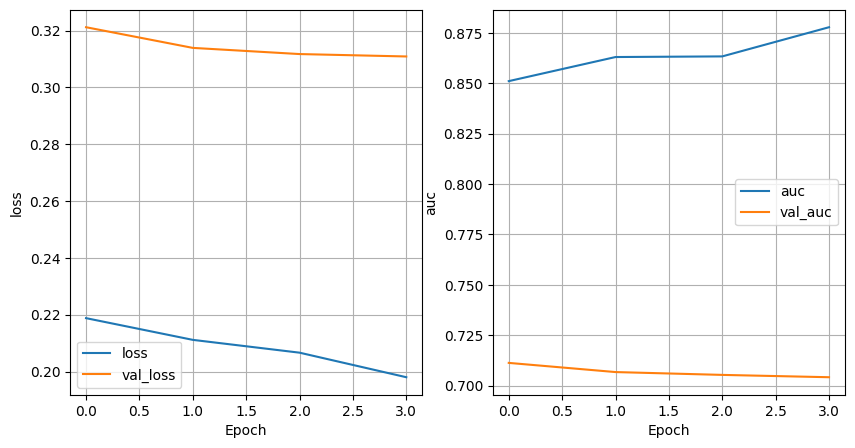

In [31]:
h = history_finetune
keys = list(h.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(h.history[keys[idx]], label=keys[idx])
    axes[idx].plot(h.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

# print( model.evaluate(full_gen, verbose=2)); 
# print( model.evaluate(train_gen, verbose=2)); 
# print( model.evaluate(valid_gen, verbose=2)); 
# print("\n\nLoss on test set {:.3},  Categorical accuracy on test set {:.3f}, AUC {:.3f}".format(test_loss, test_acc, auc))

In [ ]:

model.save('../models/resnet50,0.724auc.h5')
print("✅ Model saved")